In [ ]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

## Get time series data

In [2]:
industrial_production = (
    pdr.DataReader("IPGMFN", "fred", "1988", "2017-12").squeeze().dropna()
)
industrial_production

DATE
1988-01-01     55.6315
1988-02-01     56.8324
1988-03-01     57.5487
1988-04-01     57.7727
1988-05-01     57.8687
                ...   
2017-08-01    100.7360
2017-09-01    100.3586
2017-10-01    101.9040
2017-11-01    100.6590
2017-12-01     99.5281
Name: IPGMFN, Length: 360, dtype: float64

In [3]:
nasdaq = pdr.DataReader("NASDAQCOM", "fred", "1990", "2017-12-31").squeeze().dropna()
nasdaq

DATE
1990-01-02     459.33
1990-01-03     460.90
1990-01-04     459.39
1990-01-05     458.22
1990-01-08     458.71
               ...   
2017-12-22    6959.96
2017-12-26    6936.25
2017-12-27    6939.34
2017-12-28    6950.16
2017-12-29    6903.39
Name: NASDAQCOM, Length: 7056, dtype: float64

## Plot decomposition

In [4]:
components = tsa.seasonal_decompose(industrial_production, model="additive")
ts_df = (
    industrial_production.to_frame("original")
    .assign(trend=components.trend)
    .assign(seasonality=components.seasonal)
    .assign(residual=components.resid)
)
ts_df

,original,trend,seasonality,residual
DATE,,,,
1988-01-01,55.6315,NaN,-2.090507,NaN
1988-02-01,56.8324,NaN,-0.579679,NaN
1988-03-01,57.5487,NaN,0.747645,NaN
1988-04-01,57.7727,NaN,-0.233705,NaN
1988-05-01,57.8687,NaN,0.192588,NaN
...,...,...,...,...
2017-08-01,100.7360,NaN,0.908542,NaN
2017-09-01,100.3586,NaN,1.470945,NaN
2017-10-01,101.9040,NaN,1.508397,NaN


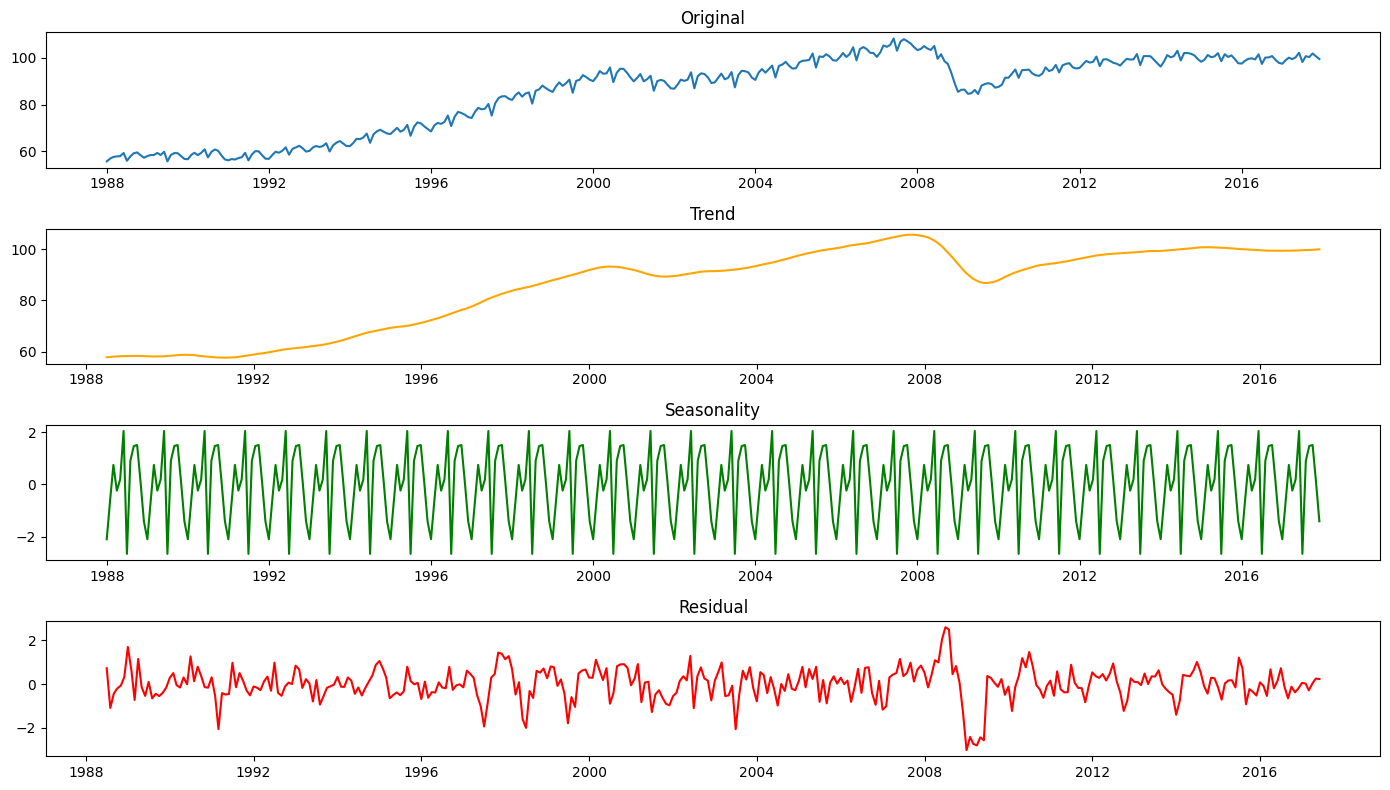

In [5]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(14, 8))
axs[0].plot(ts_df["original"])
axs[0].set_title("Original")
axs[1].plot(ts_df["trend"], color="orange")
axs[1].set_title("Trend")
axs[2].plot(ts_df["seasonality"], color="green")
axs[2].set_title("Seasonality")
axs[3].plot(ts_df["residual"], color="red")
axs[3].set_title("Residual")
plt.tight_layout()

## Log transform

In [6]:
(nasdaq == 0).any(), (industrial_production == 0).any()

(np.False_, np.False_)

In [7]:
nasdaq_log = np.log(nasdaq)
industrial_production_log = np.log(industrial_production)

## Differencing

In [8]:
nasdaq_log_diff = nasdaq_log.diff().dropna()
nasdaq_log_diff

DATE
1990-01-03    0.003412
1990-01-04   -0.003282
1990-01-05   -0.002550
1990-01-08    0.001069
1990-01-09   -0.004238
                ...   
2017-12-22   -0.000776
2017-12-26   -0.003412
2017-12-27    0.000445
2017-12-28    0.001558
2017-12-29   -0.006752
Name: NASDAQCOM, Length: 7055, dtype: float64

In [9]:
# seasonal differencing => yoy instantanteous returns
industrial_production_log_diff = industrial_production_log.diff(12).dropna()
industrial_production_log_diff

DATE
1989-01-01    0.040001
1989-02-01    0.026613
1989-03-01    0.014085
1989-04-01    0.025199
1989-05-01    0.008367
                ...   
2017-08-01    0.005890
2017-09-01    0.001489
2017-10-01    0.011061
2017-11-01    0.015342
2017-12-01    0.016682
Name: IPGMFN, Length: 348, dtype: float64

## Plots of differenced series

Display Dickey-Fuller test p-values too.

### NASDAQ

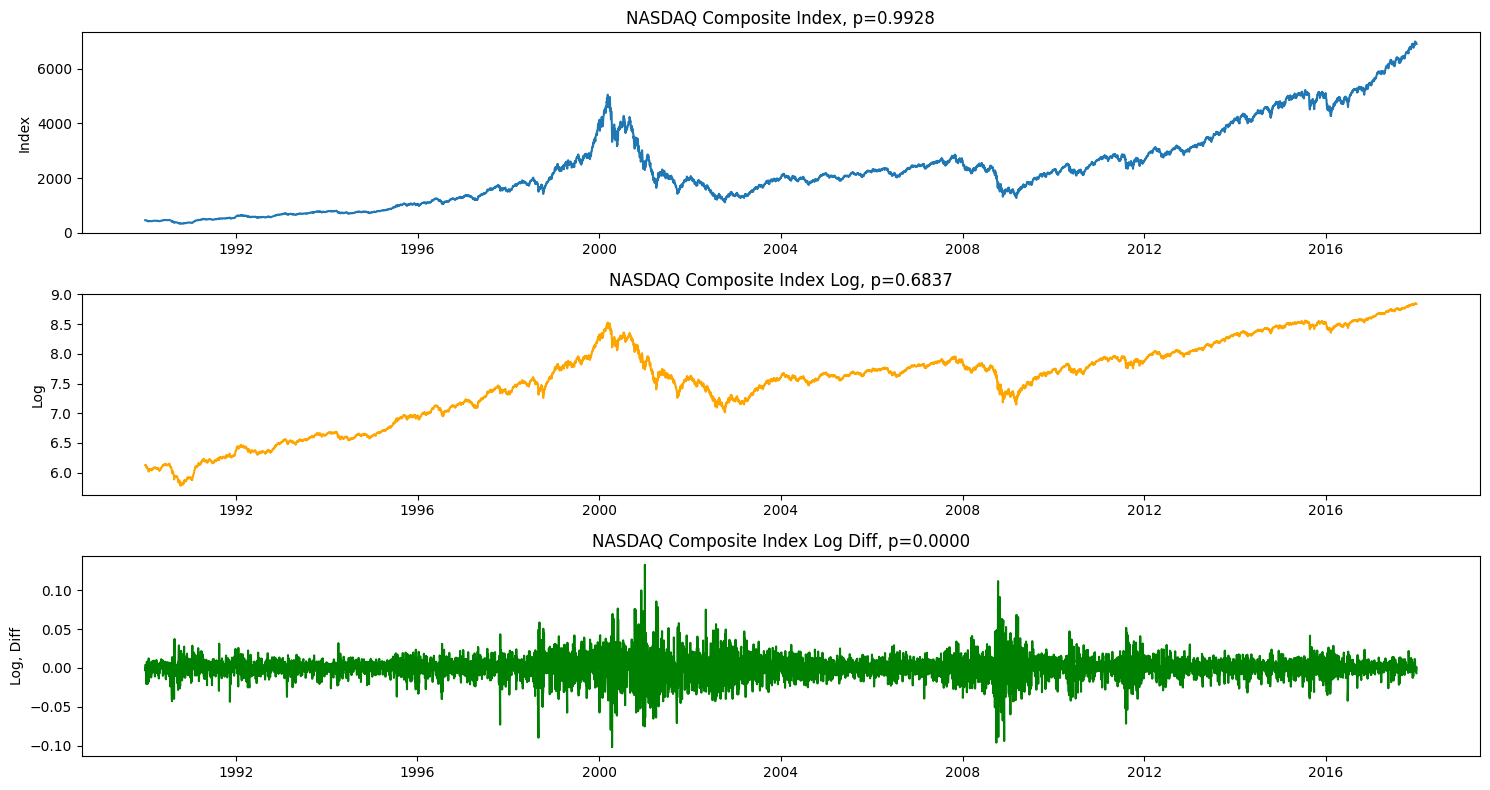

In [10]:
nasdaq_adf_p = tsa.adfuller(nasdaq)[1]
nasdaq_log_adf_p = tsa.adfuller(nasdaq_log)[1]
nasdaq_log_diff_adf_p = tsa.adfuller(nasdaq_log_diff)[1]
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 8))
axs[0].plot(nasdaq)
axs[0].set_title(f"NASDAQ Composite Index, p={nasdaq_adf_p:.4f}")
axs[0].set_ylabel("Index")
axs[1].plot(nasdaq_log, color="orange")
axs[1].set_title(f"NASDAQ Composite Index Log, p={nasdaq_log_adf_p:.4f}")
axs[1].set_ylabel("Log")
axs[2].plot(nasdaq_log_diff, color="green")
axs[2].set_title(f"NASDAQ Composite Index Log Diff, p={nasdaq_log_diff_adf_p:.4f}")
axs[2].set_ylabel("Log, Diff")
fig.tight_layout()

### Industrial production

Remember it had a 12-month lag for YoY returns.

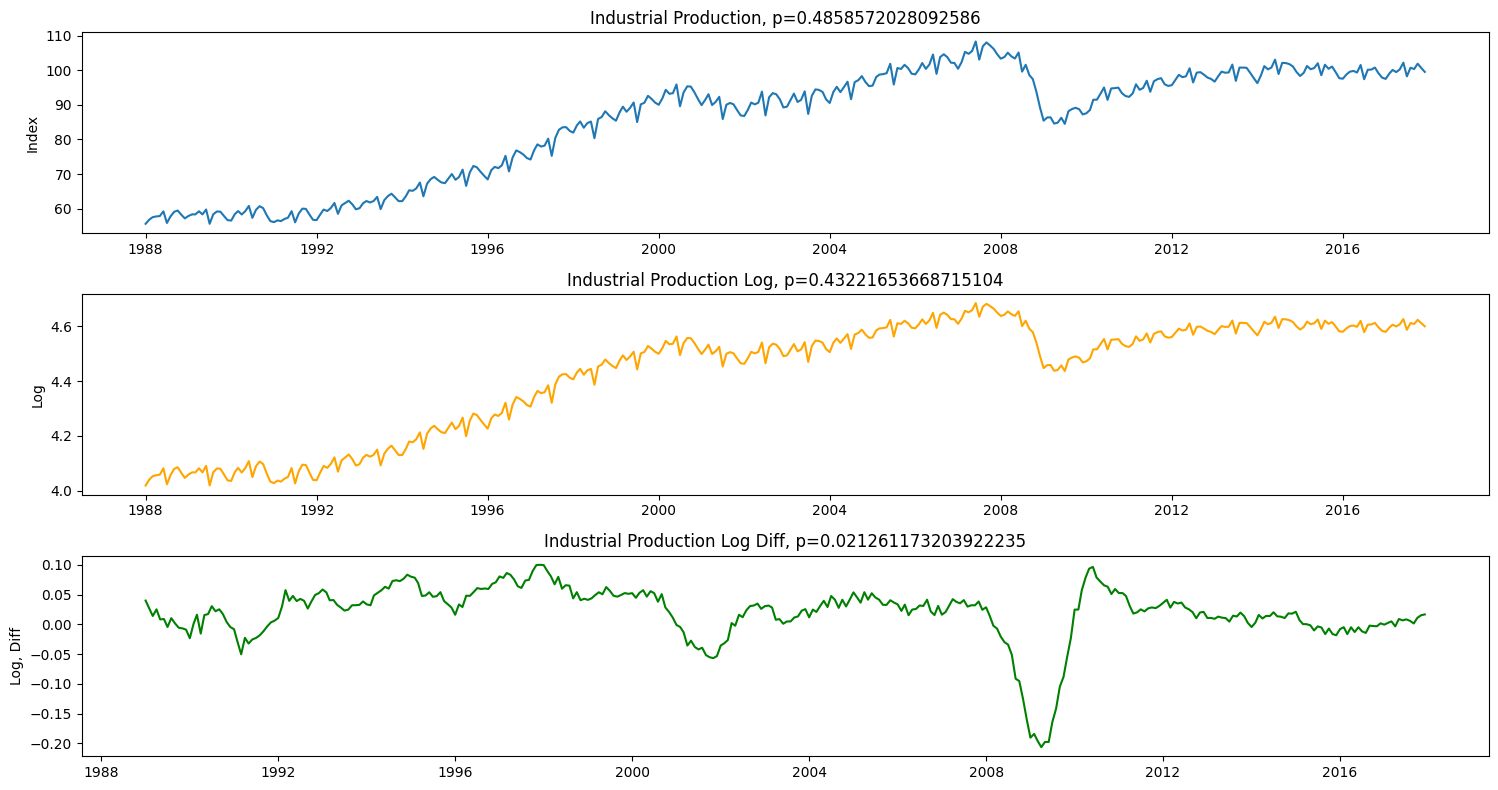

In [11]:
industrial_production_adf_p = tsa.adfuller(industrial_production)[1]
industrial_production_log_adf_p = tsa.adfuller(industrial_production_log)[1]
industrial_production_log_diff_adf_p = tsa.adfuller(industrial_production_log_diff)[1]
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 8))
axs[0].plot(industrial_production)
axs[0].set_title(f"Industrial Production, p={industrial_production_adf_p}")
axs[0].set_ylabel("Index")
axs[1].plot(industrial_production_log, color="orange")
axs[1].set_title(f"Industrial Production Log, p={industrial_production_log_adf_p}")
axs[1].set_ylabel("Log")
axs[2].plot(industrial_production_log_diff, color="green")
axs[2].set_title(
    f"Industrial Production Log Diff, p={industrial_production_log_diff_adf_p}"
)
axs[2].set_ylabel("Log, Diff")
fig.tight_layout()

In [12]:
def plot_correlogram(x, nlags, title, residual_rolling=21, acf_plot_ymax=0.1):
    q_p = np.max(q_stat(acf(x, nlags=nlags), len(x))[1])
    stats = f"Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}"
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    qq_stats = f"Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}"
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    axs[0][0].plot(x)
    axs[0][0].plot(x.rolling(residual_rolling).mean(), color="black")
    axs[0][0].text(x=0.02, y=0.85, s=stats, transform=axs[0][0].transAxes)
    axs[0][0].set_title(f"Residuals and {residual_rolling}-day rolling mean")
    probplot(x, plot=axs[0][1])
    axs[0][1].text(x=0.02, y=0.75, s=qq_stats, transform=axs[0][1].transAxes)
    axs[0][1].set_title("Q-Q")
    plot_acf(x, lags=nlags, zero=False, ax=axs[1][0])
    axs[1][0].set_xlabel("Lag")
    axs[1][0].set_ylim(-acf_plot_ymax, acf_plot_ymax)
    plot_pacf(x, lags=nlags, zero=False, ax=axs[1][1])
    axs[1][1].set_xlabel("Lag")
    axs[1][1].set_ylim(-acf_plot_ymax, acf_plot_ymax)
    fig.suptitle(f"{title}")
    fig.tight_layout()

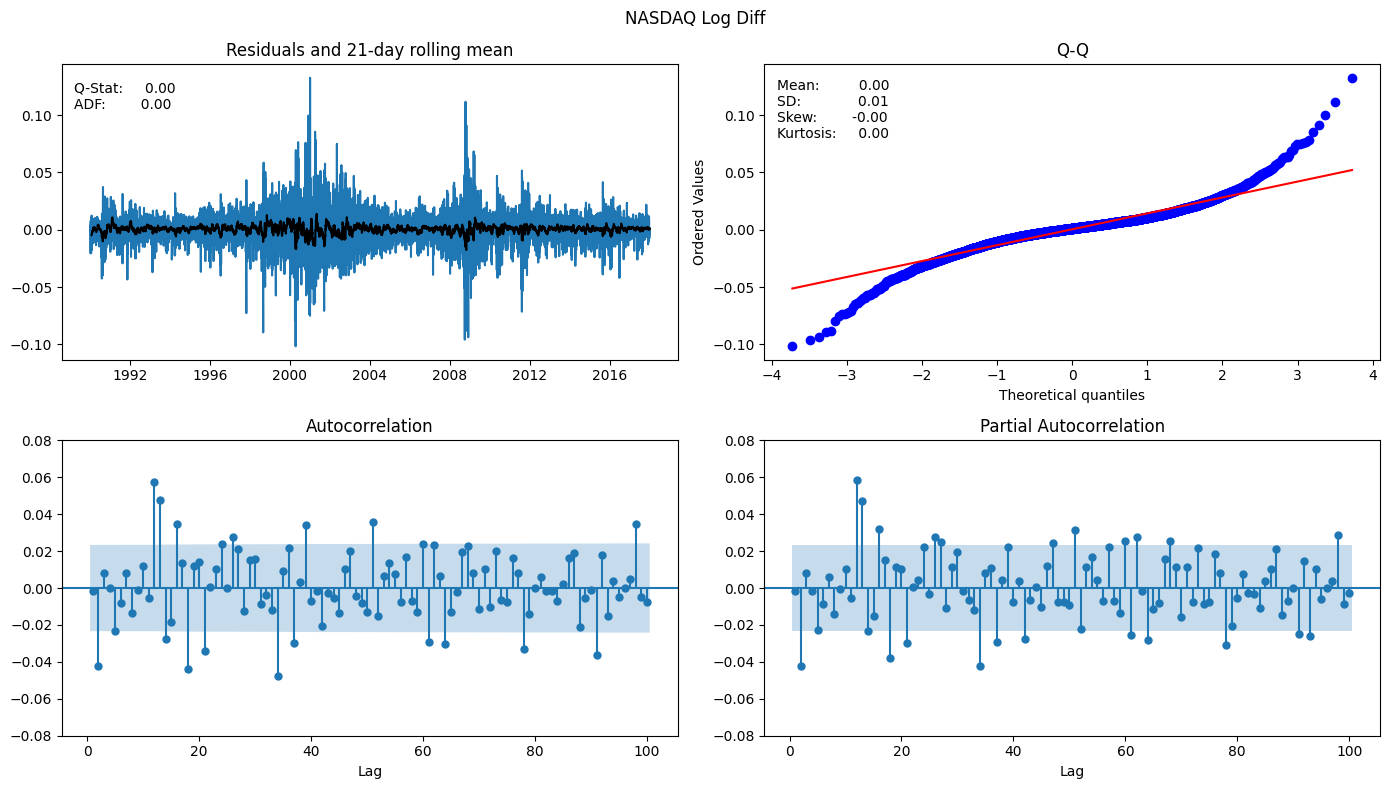

In [13]:
plot_correlogram(nasdaq_log_diff, nlags=100, title="NASDAQ Log Diff", acf_plot_ymax=0.08)

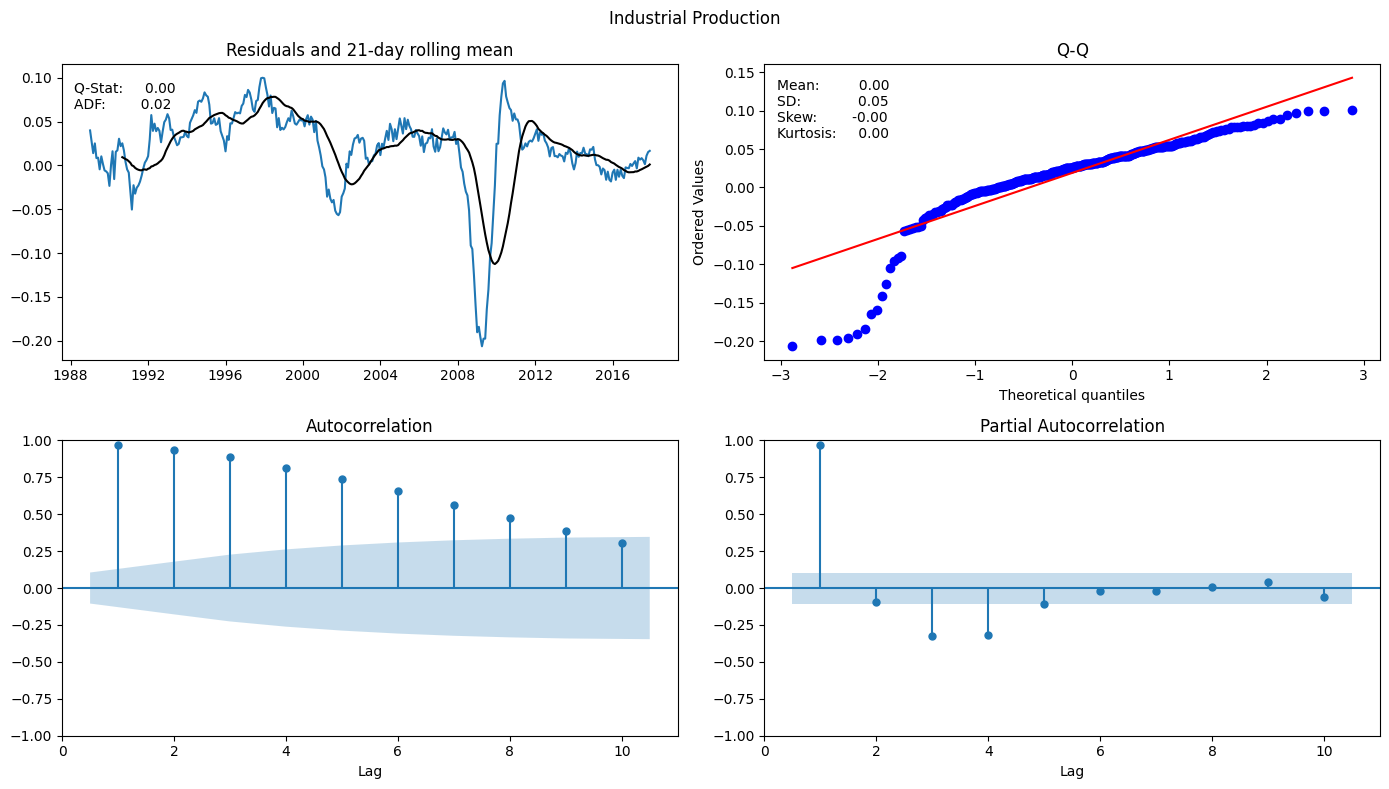

In [14]:
plot_correlogram(industrial_production_log_diff, nlags=10, title="Industrial Production", acf_plot_ymax=1.0)

## Univariate ARIMA models